### Design an algorithm to visually diagnose melanoma

In [1]:
import pandas as pd
import numpy as np
import math
import time
import os
from skimage import io, transform
import PIL

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
os.getcwd()

'/home/mkcomer237/Dropbox/Python Deep Learning/udacity_deep_learning/dermatologist-ai'

In [4]:
# Config
data_dir = './data/'
global_batch_size = 64
workers = 4
np.random.seed(10)
print(os.listdir(data_dir))
print(os.listdir(f'{data_dir}train')[0:4])

['test', 'train', 'valid']
['seborrheic_keratosis', 'nevus', 'melanoma']


### Load in the dataset and check out the images

In [5]:
# Set image transforms
img_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

img_transforms_valid = transforms.Compose([transforms.Resize(255),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])

In [33]:
train_dataset = datasets.ImageFolder(f'{data_dir}train', transform=img_transforms)
valid_dataset = datasets.ImageFolder(f'{data_dir}valid', transform=img_transforms_valid)
test_dataset = datasets.ImageFolder(f'{data_dir}test', transform=img_transforms_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=global_batch_size,
                                           num_workers= workers, pin_memory=True, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=global_batch_size,
                                           num_workers= workers, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=global_batch_size,
                                          num_workers= workers, pin_memory=True, shuffle=True)
print(len(train_loader)*global_batch_size)
print(len(valid_loader)*global_batch_size)
print(len(test_loader)*global_batch_size)

2048
192
640


**Check out some of the images**

In [7]:
# Batch size of 8
images, classes = next(iter(valid_loader))
print(images.shape)
print(classes.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [8]:
train_dataset.classes

['melanoma', 'nevus', 'seborrheic_keratosis']

In [9]:
# Helper function to de-normalize and plot images
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image * np.array((0.229, 0.224, 0.225)).reshape(3, 1, 1) + np.array((0.485, 0.456, 0.406)).reshape(3, 1, 1)
    img = (image * 255).astype(np.uint8) # unnormalize
    

    return plt.imshow(np.transpose(img, (1, 2, 0)))

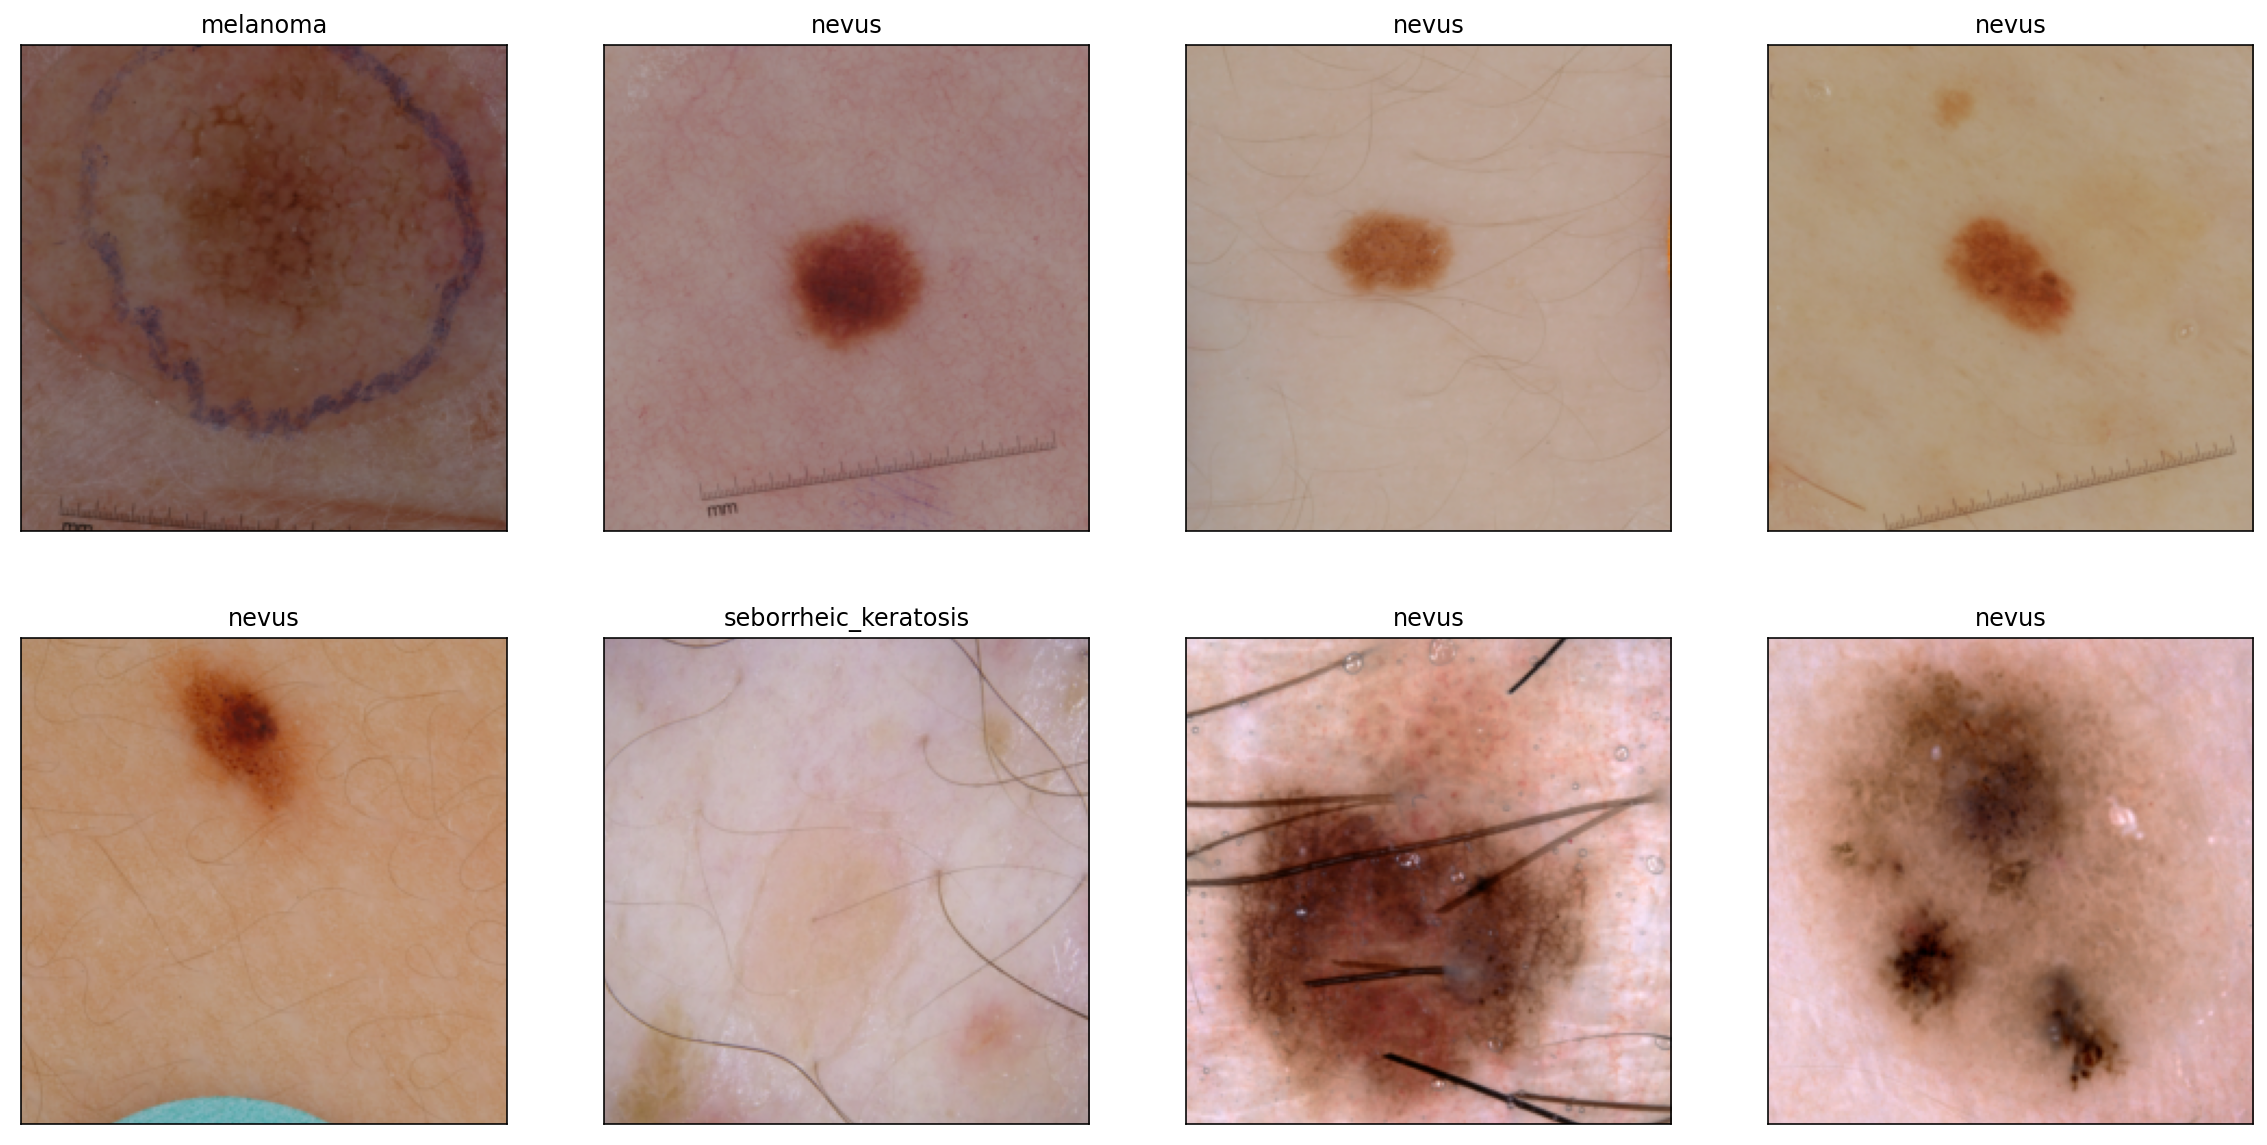

In [10]:
# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    im_convert(images[idx])
    ax.set_title(train_dataset.classes[classes[idx]])

### Define the model structure

Use transfer learning??
Resnet?

In [250]:
model = models.resnet50(pretrained=True)

# Disable gradients on all model parameters to freeze the weights
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Dropout(p=0.4),
                         nn.Linear(2048, 128),
                         nn.Dropout(p=0.4),
                         nn.ReLU(),
                         nn.Linear(128, 3),
                         nn.LogSoftmax())

for param in model.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last layer in the model

for param in model.layer3[3:5].parameters():
    param.requires_grad = True

for param in model.layer4[0:2].parameters():
    param.requires_grad = True

In [251]:
model.layer4[2].parameters()

<generator object Module.parameters at 0x7f120829ed60>

In [252]:
torch.manual_seed(13)

criterion = nn.NLLLoss()

#Adam with L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=1)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 3, 6, 10], gamma=0.3)

In [253]:
# Load a batch to test out the forward pass
images, classes = next(iter(train_loader))
with torch.no_grad():
    output = model(images)
    loss = criterion(output, classes)
    math.sqrt(loss.item()/64)

In [254]:
print(torch.exp(output)[0:3, :])
print(classes[0:3])
print(loss)

tensor([[0.4367, 0.2086, 0.3547],
        [0.2665, 0.3095, 0.4240],
        [0.3810, 0.3592, 0.2598]])
tensor([1, 0, 1])
tensor(1.1484)


In [255]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Train the model

In [256]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.cuda.get_device_name()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print(f'CUDA is available!  Training on GPU {device}...')
    
if train_on_gpu:
    model.cuda()

CUDA is available!  Training on GPU NVIDIA TITAN X (Pascal)...


In [257]:
# number of epochs to train the model
# Use 40 epochs

n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):
    
    start = time.time()
    current_lr = scheduler.get_last_lr()[0]
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # put in training mode (enable dropout)
    model.train()
    for images, classes in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, classes = images.cuda(), classes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        # the annotations get added in the dense layers
        output = model(images)
        # print(output.dtype)
        # print(scores.dtype)
        # calculate the batch loss
        loss = criterion(output, classes)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # eval mode (no dropout)
    model.eval()
    with torch.no_grad():
        for images, classes in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, classes = images.cuda(), classes.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, classes)
            # update average validation loss 
            valid_loss += loss.item()
    
    # calculate RMSE
    train_loss = math.sqrt(train_loss/len(train_loader.sampler))
    valid_loss = math.sqrt(valid_loss/len(valid_loader.sampler))
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # increment learning rate decay
    scheduler.step()
    
    # print training/validation statistics 
    # print(f'Epoch: {e}, {float(time.time() - start):.3f} seconds, lr={optimizer.lr}')
    print('Epoch: {}, time: {:.3f}s, lr: {:.6f} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, float(time.time() - start), current_lr, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), f'dermatologist_ia_best_model.pt')
        valid_loss_min = valid_loss    

Epoch: 1, time: 79.047s, lr: 0.000200 	Training Loss: 0.109149 	Validation Loss: 0.128721
Validation loss decreased (inf --> 0.128721).  Saving model ...
Epoch: 2, time: 77.086s, lr: 0.000060 	Training Loss: 0.097120 	Validation Loss: 0.122129
Validation loss decreased (0.128721 --> 0.122129).  Saving model ...
Epoch: 3, time: 78.376s, lr: 0.000060 	Training Loss: 0.091707 	Validation Loss: 0.118564
Validation loss decreased (0.122129 --> 0.118564).  Saving model ...
Epoch: 4, time: 80.749s, lr: 0.000018 	Training Loss: 0.086275 	Validation Loss: 0.122578
Epoch: 5, time: 75.938s, lr: 0.000018 	Training Loss: 0.082570 	Validation Loss: 0.113422
Validation loss decreased (0.118564 --> 0.113422).  Saving model ...
Epoch: 6, time: 81.148s, lr: 0.000018 	Training Loss: 0.080370 	Validation Loss: 0.123608
Epoch: 7, time: 78.901s, lr: 0.000005 	Training Loss: 0.077365 	Validation Loss: 0.117681
Epoch: 8, time: 81.997s, lr: 0.000005 	Training Loss: 0.077218 	Validation Loss: 0.116885
Epoch: 9,

best score: 0.11055738760810928


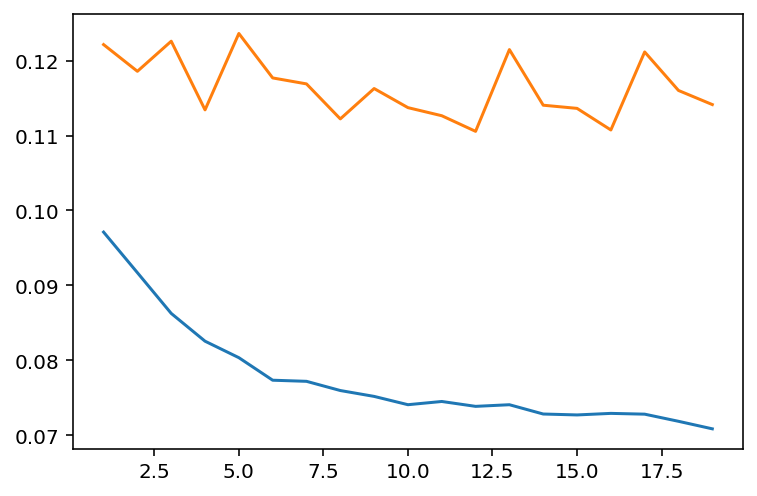

In [258]:
# Plot the losses
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(1, len(train_losses))), train_losses[1:])
ax.plot(list(range(1, len(valid_losses))), valid_losses[1:]);
print(f'best score: {valid_loss_min}')

In [259]:
best score: 0.11120415014205647
best score: 0.10869485004792508

SyntaxError: invalid syntax (1536451345.py, line 1)

### Test Dataset Accuracy Metrics and ROC

In [260]:
# Calculate predictions and loss on the test dataset

melanoma_probs = []
melanoma_preds = []
melanoma_actuals = []

model.load_state_dict(torch.load('dermatologist_ia_best_model.pt'))

test_loss = 0.0
# Putting in eval mode necessary for maximimum accuracy
model.eval()
with torch.no_grad():
    for images, classes in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, classes = images.cuda(), classes.cuda()

        # Calculate the output and loss on the test set
        output = model(images)
        loss = criterion(output, classes)
        test_loss += loss.item()
        
        # Convert to probabilities
        output_probs = torch.exp(output)
        #print('next_batch', len(melanoma_probs), len(images), len(output), len(output_probs))

        # Save to a longer list of probs, preds, and actuals
        # Predicted probabilities for melanoma
        melanoma_probs.extend(list(output_probs[:, 0].reshape(-1).cpu().detach().numpy()))
        melanoma_actuals.extend(list(torch.where(classes == 0, 1, 0).cpu().detach().numpy()))
        
test_loss = math.sqrt(test_loss/len(test_loader.sampler))
print('Final length: ', len(melanoma_probs))
print('Test loss: ', test_loss)

Final length:  600
Test loss:  0.0975152419272789


In [261]:
# Function to calculate accuracy metrics for a given cutoff

def accuracy_metrics(cutoff, melanoma_probs, melanoma_actuals):

    melanoma_probs = np.array(melanoma_probs)
    melanoma_preds = np.where(melanoma_probs>=cutoff, 1, 0)
    melanoma_actuals = np.array(melanoma_actuals)


    n_obs = len(melanoma_preds)

    correct, tp, fp, tn, fn = 0, 0, 0, 0, 0

    for pred, actual in zip(melanoma_preds, melanoma_actuals):
        if pred == actual: correct +=1
        if pred == 1 and actual == 1: tp += 1
        if pred == 1 and actual == 0: fp += 1
        if pred == 0 and actual == 0: tn += 1
        if pred == 0 and actual == 1: fn += 1

    accuracy = correct/n_obs
    sensitivity = tp/(tp + fn)
    specificity = tn/(fp + tn)
    
    return accuracy, sensitivity, specificity, n_obs, {'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}

# Print out metrics for a single cutoff
accuracy, sensitivity, specificity, n_obs, counts = accuracy_metrics(0.2, melanoma_probs, melanoma_actuals)
print('Accuracy: ', accuracy)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print('Total obs: ', n_obs)
print('Actual positives: ', counts['tp'] + counts['fn'])
print('Actual negatives: ', counts['fp'] + counts['tn'])

Accuracy:  0.8033333333333333
Sensitivity:  0.6495726495726496
Specificity:  0.8405797101449275
Total obs:  600
Actual positives:  117
Actual negatives:  483


AUC 0.8441365397887136


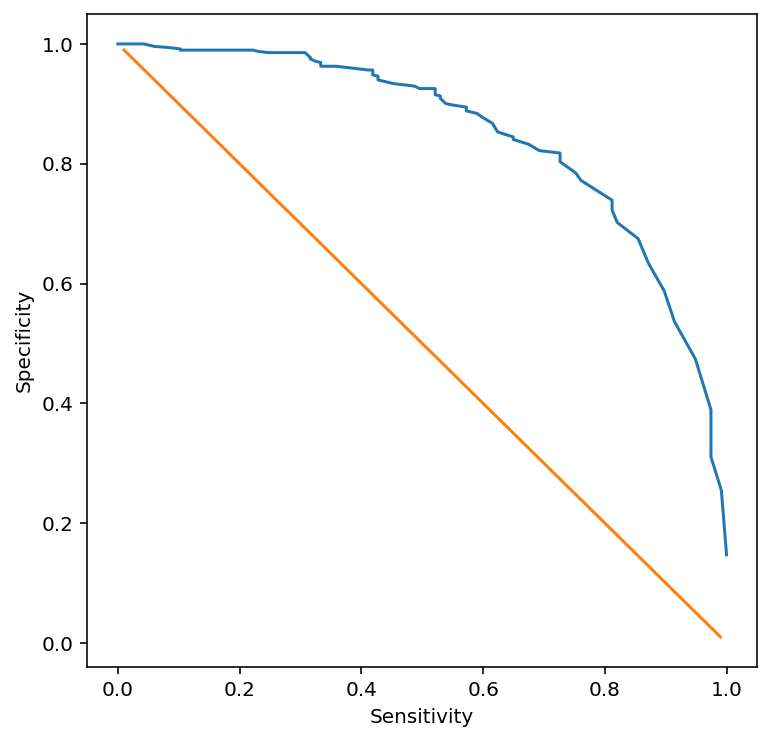

In [262]:
# Calculate an ROC curve and AUC metric

sens_x = []
spec_y = []
x = []
y = []
last_specificity = 0.0
auc = 0.0

for cutoff in np.arange(0.01, 1.00, 0.01):
    accuracy, sensitivity, specificity, n_obs, counts = accuracy_metrics(cutoff, melanoma_probs, melanoma_actuals)
    # print(sensitivity, specificity, last_specificity)
    auc += sensitivity * (specificity - last_specificity) # y height * x step size
    sens_x.append(sensitivity)
    spec_y.append(specificity)
    x.append(cutoff)
    y.append(1-cutoff)
    last_specificity = specificity

# Plot the ROC Curve

fig = plt.figure()
ax = plt.axes()
ax.plot(sens_x, spec_y)
ax.plot(x, y);
ax.set_ylabel('Specificity')
ax.set_xlabel('Sensitivity')
fig.set_size_inches(6, 6)

# Calculate AUC

print('AUC', auc)

In [263]:
# Baseline: 
# 67% accuracy
# 0.74

#80.8% accuracy
#AUC 0.829944612553308

#Accuracy:  0.8066666666666666 
#AUC 0.8052414574153699
